In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

from PIL import Image

## Fast a.i augmentations

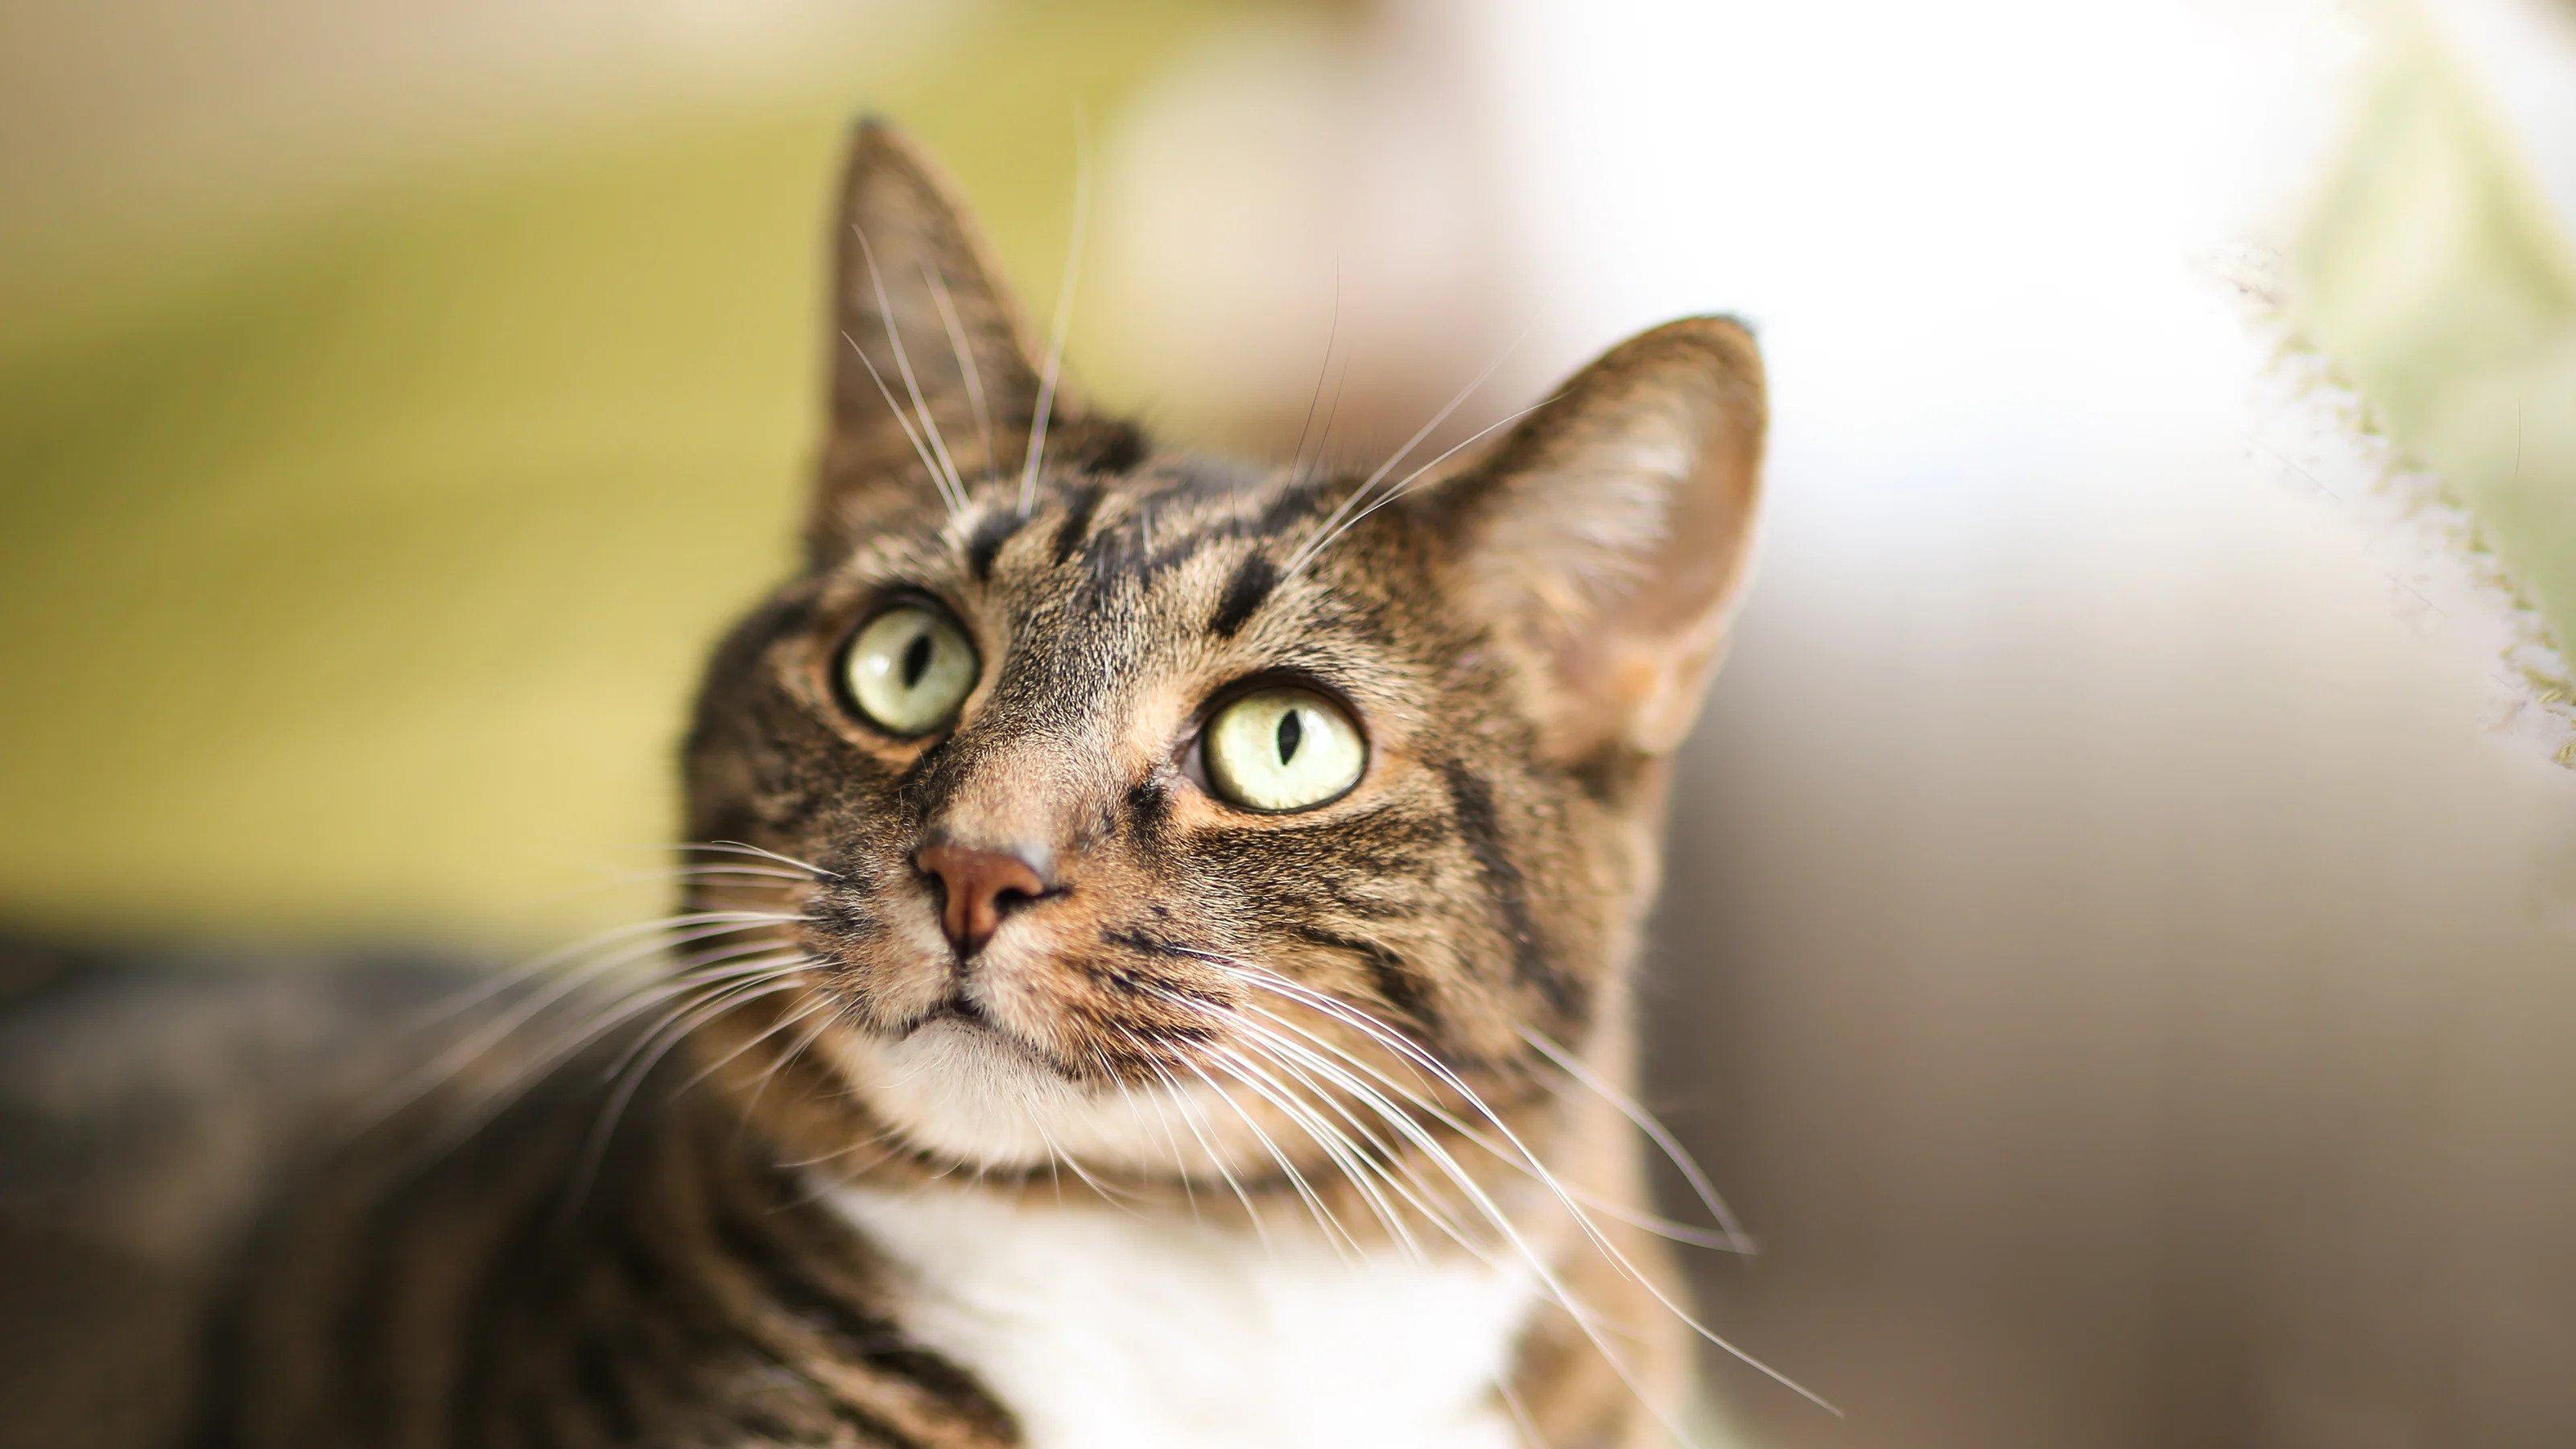

In [ ]:
imgt = open_image('datasets/cat.jpg')
imgt

In [ ]:
PATCH_SIZE = 500

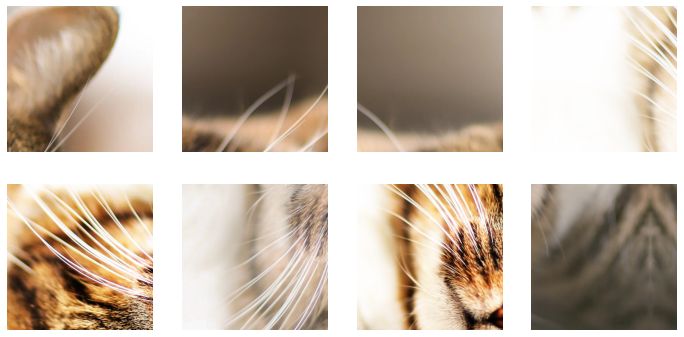

In [ ]:
#test augmentations settings
def get_ex(): return open_image('datasets/cat.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms, **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

imgt = open_image('datasets/cat.jpg')

crop_rand_patches = crop(size=(PATCH_SIZE,PATCH_SIZE),  row_pct=(0,1), col_pct=(0,1))# pct 

#tfms = get_transforms(max_zoom=1.0, max_lighting=0.0, max_warp=0.0)
tfms = [crop_rand_patches, dihedral_affine()]

max_lighting = 0.5
p_lighting = 0.8
tfms.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
tfms.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))

plots_f(2, 4, 12, 6, size=None, resize_method=ResizeMethod.NO)

In [ ]:
img = PIL.Image.open("datasets/cat.jpg")

In [ ]:
2040 / 480

4.25

In [ ]:
img.size

(3200, 1800)

In [ ]:
img.crop((10,10,20,20))

In [ ]:
patch_size = 480

In [ ]:
n_patches_x = img.size[0] // patch_size
n_patches_y = img.size[1] // patch_size

if img.size[0] % patch_size > 0: n_patches_x += 1
if img.size[1] % patch_size > 0: n_patches_y += 1

coords = []
    
for i in range(n_patches_x):
    for j in range(n_patches_y):
        coords.append((i * patch_size,j * patch_size, (i+1)*patch_size,(j+1)*patch_size))
        print(coords[-1])
        

(0, 0, 480, 480)
(0, 480, 480, 960)
(0, 960, 480, 1440)
(0, 1440, 480, 1920)
(480, 0, 960, 480)
(480, 480, 960, 960)
(480, 960, 960, 1440)
(480, 1440, 960, 1920)
(960, 0, 1440, 480)
(960, 480, 1440, 960)
(960, 960, 1440, 1440)
(960, 1440, 1440, 1920)
(1440, 0, 1920, 480)
(1440, 480, 1920, 960)
(1440, 960, 1920, 1440)
(1440, 1440, 1920, 1920)
(1920, 0, 2400, 480)
(1920, 480, 2400, 960)
(1920, 960, 2400, 1440)
(1920, 1440, 2400, 1920)
(2400, 0, 2880, 480)
(2400, 480, 2880, 960)
(2400, 960, 2880, 1440)
(2400, 1440, 2880, 1920)
(2880, 0, 3360, 480)
(2880, 480, 3360, 960)
(2880, 960, 3360, 1440)
(2880, 1440, 3360, 1920)


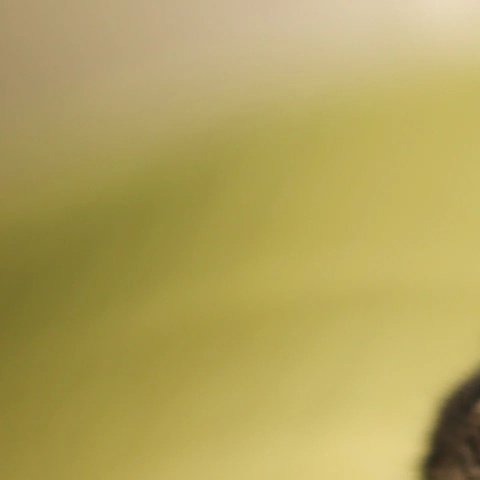

In [ ]:
img.resize((img.size[0] // 2,img.size[1] // 2)).crop(coords[0])

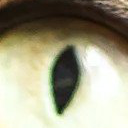

In [ ]:
imgt.crop_pad(size=128)

In [ ]:

for i in range(10):

    patch_size = 100
    coords = (i * patch_size,i * patch_size, (i+1)*patch_size,(i+1)*patch_size)
    cropped = imgt.copy().crop(coords)
    cropped.show()

AttributeError: 'Tensor' object has no attribute 'copy'

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Setting up Perceptual loss...
Loading model from: /home/luslad/thesis/PerceptualSimilarity/models/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [ ]:
from srthesis.utils import *
select_gpu()

GPUs:2
Selected GPU:2
Available memory:9544MB


In [ ]:
import fastai
import torch
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from srthesis.data import *
from srthesis.loss import *
from srthesis.metrics import *
from srthesis.callbacks import *
from srthesis.model import *

## Create dataset

Zatím jen pro otestování trénování vezmu DIV2K a sám si ho zmenším a uložím ve špatné JPEG kvalitě. O něco se postará bluring v Learner class, ale cílem je ještě přidat šum a nějaký uvěřitelný blur a následně to porovnat s RealSR datasetem. Pokud tam bude vidět zlepšení, zkusím se posunout k vytváření trénovacího setu uměle pomocí NN.

In [ ]:
proj_id = 'base_model'

gen_name = proj_id + '_gen'
pre_gen_name = gen_name + '_0'
crit_name = proj_id + '_crit'

name_gen = proj_id + '_image_gen'
path_gen = path_dataset/name_gen

TENSORBOARD_PATH = Path('data/tensorboard/' + proj_id)


pct_start = 1e-8

Functions for obtaining DataBunch (which is serving training batches), including a dummy one for fast testing.

Show some example inputs and targets in task

$ {LR}_{256px} -> {HR}_{512px} $

In [ ]:
# I need data further for getting denormalizations, don't remove
data = get_data(128, 8)

In [ ]:
metrics = [AverageMetric(PSNR), AverageMetric(SSIM), AverageMetric(LPIPS)]

In [ ]:
arch = models.resnet34

In [ ]:
bs,size=32,128

In [ ]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=metrics, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

## Cropping to correct patch size

In [ ]:
# 1. najit si cestu k datasetu

# 2. vzit o